# I. Import module

In [1]:
# module for process data
import pandas as pd
import numpy as np

# module for visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import time

# module for machine learning
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf

# II. Load csv files & Split data & Data Pre-processing)

## 1. NIR BenchMark Data (Without Pre-processing)
- BenchMark

In [6]:
# load NIR BenchMark data csv file
X = pd.read_csv("./NIR_Spectrum_data.csv")
X_data = X.values[:,2:]

# load y_data & wavelength csv file
y_data = X.values[0:,0]
y_data_class = X.values[0:,1]
wavelength = pd.read_csv("./wavelength.csv")
wavelength = wavelength.values[:,0:]

# to float32
X_data = np.asarray(X_data).astype('float32')
y_data = np.asarray(y_data).astype('float32')

# split X_data -> train, validation, test
X_train = X_data[0:249]
X_validation = X_data[249:397]
X_test = X_data[397:497]

# split y_data -> train, validation, test (4 categories in each data: 1 = Aluminium, 2 = Cardboard/Paper, 3 = HDPE, 4 = PET)
y_train = y_data[0:249]
y_validation = y_data[249:397]
y_test = y_data[397:497]

# split y_data_class -> train, validation, test (4 categories in each data: Aluminium, Cardboard/Paper, HDPE, PET)
y_train_class = y_data_class[0:249]
y_validation_class = y_data_class[249:397]
y_test_class = y_data_class[397:497]

# show data shape
print('Training data shape:',X_train.shape)
print('Validation data shape:',X_validation.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (249, 124)
Validation data shape: (148, 124)
Testing data shape: (100, 124)


## 2. MSC Pre-processing Data
- MSC

In [3]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

Xmsc_data = msc(X_data)[0] # Take the first element of the output tuple

# split Xmsc_data -> train, validation, test
Xmsc_train = Xmsc_data[0:249]
Xmsc_validation = Xmsc_data[249:397]
Xmsc_test = Xmsc_data[397:497]

# show data shape
print('MSC Training data shape:',Xmsc_train.shape)
print('MSC Validation data shape:',Xmsc_validation.shape)
print('MSC Testing data shape:',Xmsc_test.shape)

MSC Training data shape: (249, 124)
MSC Validation data shape: (148, 124)
MSC Testing data shape: (100, 124)


## 3. NIR After SNV Pre-processing Data
- SNV

In [4]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

Xsnv_data = snv(X_data)

# split Xsnv_data -> train, validation, test
Xsnv_train = Xsnv_data[0:249]
Xsnv_validation = Xsnv_data[249:397]
Xsnv_test = Xsnv_data[397:497]

# show data shape
print('SNV Training data shape:',Xsnv_train.shape)
print('SNV Validation data shape:',Xsnv_validation.shape)
print('SNV Testing data shape:',Xsnv_test.shape)

SNV Training data shape: (249, 124)
SNV Validation data shape: (148, 124)
SNV Testing data shape: (100, 124)


# III. Visualize Spectrum Data

## 1. NIR BenchMark Data (Without Pre-processing)
- BenchMark

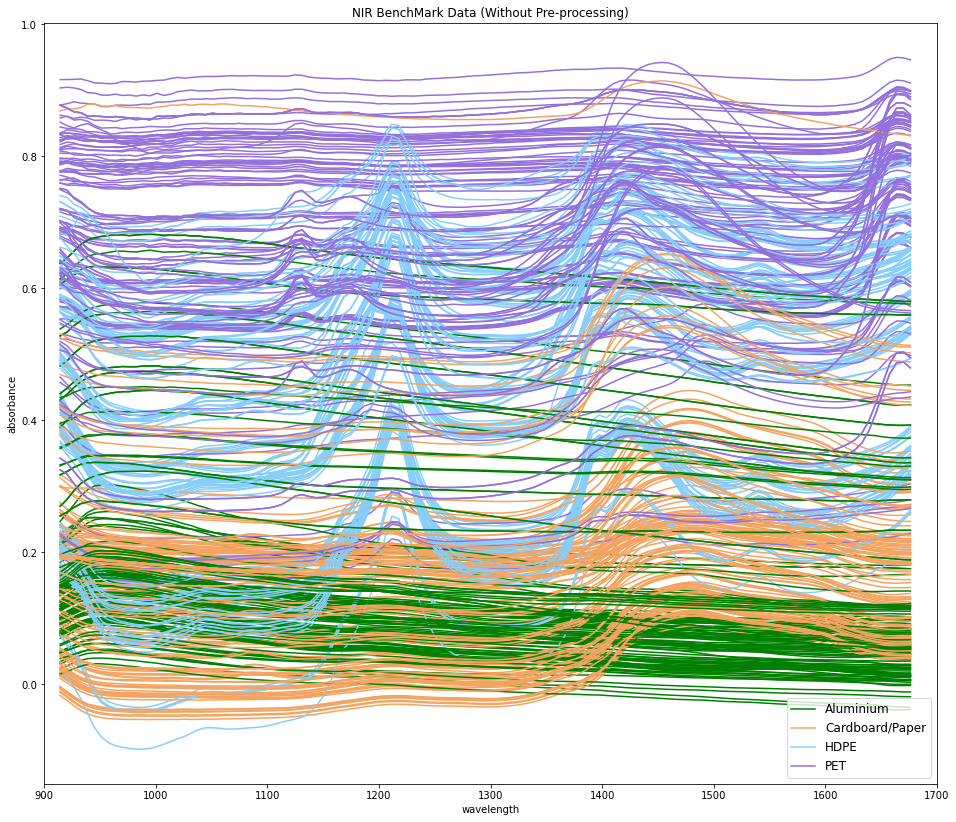

In [7]:
# Plot NIR BenchMark data
plt.figure(figsize=(16, 14))
plt.title('NIR BenchMark Data (Without Pre-processing)')
plt.xlabel('wavelength')
plt.ylabel('absorbance')
plt.xlim(900.0, 1700.0)

# set label & color for 4 categories: Aluminium, Cardboard/Paper, HDPE, PET
Aluminium, = plt.plot(wavelength, X_data[0], color="green")
Cardboard, = plt.plot(wavelength, X_data[63], color="sandybrown")
HDPE, = plt.plot(wavelength, X_data[126], color="lightskyblue")
PET, = plt.plot(wavelength, X_data[189], color="mediumpurple")

# plot X_train BenchMark data
for i in range(63):
    plt.plot(wavelength, X_data[i], color="green", label='Aluminium')
for i in range(63,126):
    plt.plot(wavelength, X_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(126,189):
    plt.plot(wavelength, X_data[i], color="lightskyblue", label='HDPE')
for i in range(189,249):
    plt.plot(wavelength, X_data[i], color="mediumpurple", label='PET')
    
# plot X_validation BenchMark data
for i in range(249,286):
    plt.plot(wavelength, X_data[i], color="green", label='Aluminium')
for i in range(286,323):
    plt.plot(wavelength, X_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(323,360):
    plt.plot(wavelength, X_data[i], color="lightskyblue", label='HDPE')
for i in range(360,397):
    plt.plot(wavelength, X_data[i], color="mediumpurple", label='PET')
    
# plot X_test BenchMark data
for i in range(397,422):
    plt.plot(wavelength, X_data[i], color="green", label='Aluminium')
for i in range(422,447):
    plt.plot(wavelength, X_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(447,472):
    plt.plot(wavelength, X_data[i], color="lightskyblue", label='HDPE')
for i in range(472,497):
    plt.plot(wavelength, X_data[i], color="mediumpurple", label='PET')

plt.legend([Aluminium, Cardboard, HDPE, PET], ["Aluminium", "Cardboard/Paper", "HDPE", "PET"], fontsize=12, loc='best')
# #plt.savefig('NIR BenchMark Data.png')

## 2. NIR After MSC Pre-processig Data
- MSC

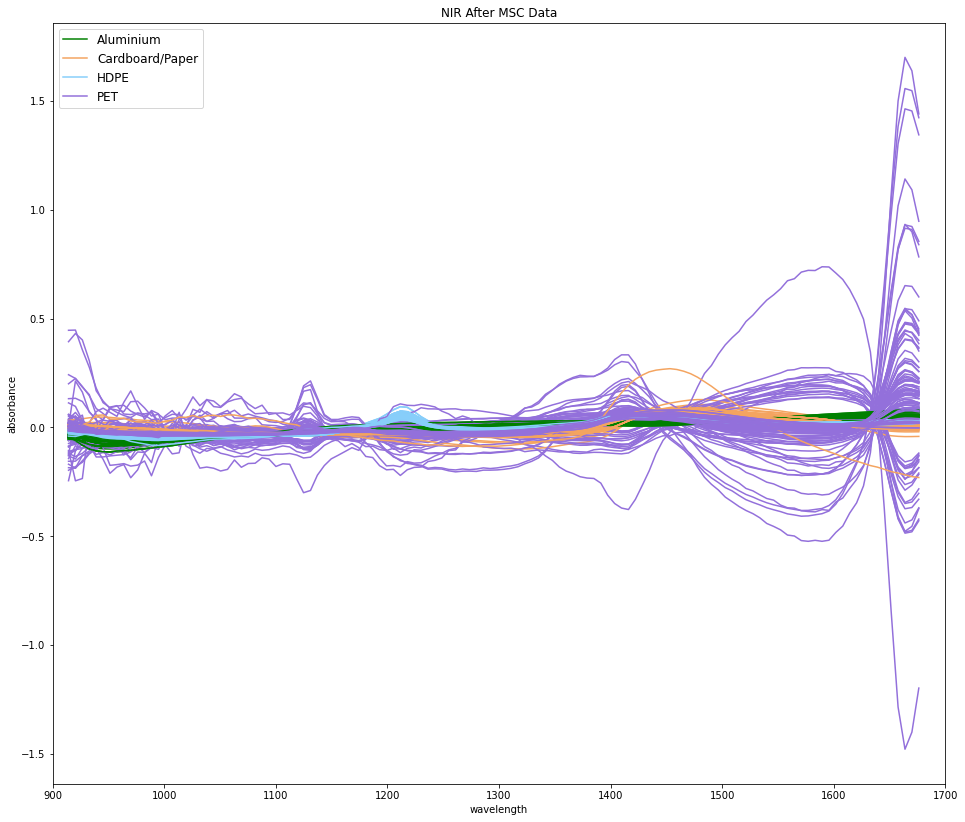

In [8]:
# Plot NIR MSC data
plt.figure(figsize=(16, 14))
plt.title('NIR After MSC Data')
plt.xlabel('wavelength')
plt.ylabel('absorbance')
plt.xlim(900.0, 1700.0)

# set label & color for 4 categories: Aluminium, Cardboard/Paper, HDPE, PET
Aluminium, = plt.plot(wavelength, Xmsc_data[0], color="green")
Cardboard, = plt.plot(wavelength, Xmsc_data[63], color="sandybrown")
HDPE, = plt.plot(wavelength, Xmsc_data[126], color="lightskyblue")
PET, = plt.plot(wavelength, Xmsc_data[189], color="mediumpurple")

# plot X_train MSC data
for i in range(63):
    plt.plot(wavelength, Xmsc_data[i], color="green", label='Aluminium')
for i in range(63,126):
    plt.plot(wavelength, Xmsc_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(126,189):
    plt.plot(wavelength, Xmsc_data[i], color="lightskyblue", label='HDPE')
for i in range(189,249):
    plt.plot(wavelength, Xmsc_data[i], color="mediumpurple", label='PET')
    
# plot X_validation MSC data
for i in range(249,286):
    plt.plot(wavelength, Xmsc_data[i], color="green", label='Aluminium')
for i in range(286,323):
    plt.plot(wavelength, Xmsc_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(323,360):
    plt.plot(wavelength, Xmsc_data[i], color="lightskyblue", label='HDPE')
for i in range(360,397):
    plt.plot(wavelength, Xmsc_data[i], color="mediumpurple", label='PET')
    
# plot X_test MSC data
for i in range(397,422):
    plt.plot(wavelength, Xmsc_data[i], color="green", label='Aluminium')
for i in range(422,447):
    plt.plot(wavelength, Xmsc_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(447,472):
    plt.plot(wavelength, Xmsc_data[i], color="lightskyblue", label='HDPE')
for i in range(472,497):
    plt.plot(wavelength, Xmsc_data[i], color="mediumpurple", label='PET')

plt.legend([Aluminium, Cardboard, HDPE, PET], ["Aluminium", "Cardboard/Paper", "HDPE", "PET"], fontsize=12, loc='best')
# #plt.savefig('NIR MSC Data.png')

## 3. NIR After SNV Pre-processig Data
- SNV

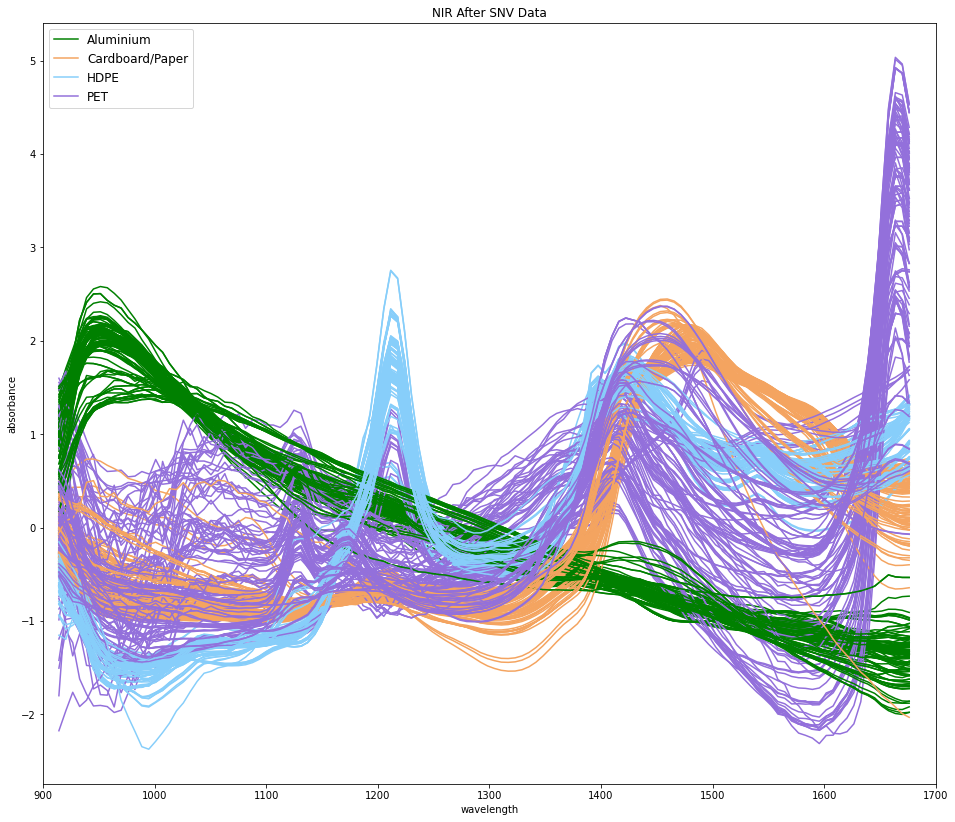

In [9]:
# Plot NIR SNV data
plt.figure(figsize=(16, 14))
plt.title('NIR After SNV Data')
plt.xlabel('wavelength')
plt.ylabel('absorbance')
plt.xlim(900.0, 1700.0)

# set label & color for 4 categories: Aluminium, Cardboard/Paper, HDPE, PET
Aluminium, = plt.plot(wavelength, Xsnv_data[0], color="green")
Cardboard, = plt.plot(wavelength, Xsnv_data[63], color="sandybrown")
HDPE, = plt.plot(wavelength, Xsnv_data[126], color="lightskyblue")
PET, = plt.plot(wavelength, Xsnv_data[189], color="mediumpurple")

# plot X_train SNV data
for i in range(63):
    plt.plot(wavelength, Xsnv_data[i], color="green", label='Aluminium')
for i in range(63,126):
    plt.plot(wavelength, Xsnv_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(126,189):
    plt.plot(wavelength, Xsnv_data[i], color="lightskyblue", label='HDPE')
for i in range(189,249):
    plt.plot(wavelength, Xsnv_data[i], color="mediumpurple", label='PET')
    
# plot X_validation SNV data
for i in range(249,286):
    plt.plot(wavelength, Xsnv_data[i], color="green", label='Aluminium')
for i in range(286,323):
    plt.plot(wavelength, Xsnv_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(323,360):
    plt.plot(wavelength, Xsnv_data[i], color="lightskyblue", label='HDPE')
for i in range(360,397):
    plt.plot(wavelength, Xsnv_data[i], color="mediumpurple", label='PET')
    
# plot X_test SNV data
for i in range(397,422):
    plt.plot(wavelength, Xsnv_data[i], color="green", label='Aluminium')
for i in range(422,447):
    plt.plot(wavelength, Xsnv_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(447,472):
    plt.plot(wavelength, Xsnv_data[i], color="lightskyblue", label='HDPE')
for i in range(472,497):
    plt.plot(wavelength, Xsnv_data[i], color="mediumpurple", label='PET')

plt.legend([Aluminium, Cardboard, HDPE, PET], ["Aluminium", "Cardboard/Paper", "HDPE", "PET"], fontsize=12, loc='best')
# #plt.savefig('NIR SNV Data.png')

# IV. Classification

# 1. Machine Learning

## 1.1. SVM (Support Vector Machine)

### SVM - Linear kernel
- BenchMark - confusion matrix

NIR BenchMark Data Training time: 0.3610384464263916s
SVM (linear kernel)'s accuracy on BenchMark data training set is 98.39%
SVM (linear kernel)'s accuracy on BenchMark data validation set is 97.30%
SVM (linear kernel)'s accuracy on BenchMark data test set is 89.00%
-----------------------------------------------------------------
SVM (linear kernel) classification on [NIR BenchMark data test set] report: 

                 precision    recall  f1-score   support

      Aluminium       1.00      0.92      0.96        25
Cardboard/Paper       0.75      0.96      0.84        25
           HDPE       1.00      1.00      1.00        25
            PET       0.85      0.68      0.76        25

       accuracy                           0.89       100
      macro avg       0.90      0.89      0.89       100
   weighted avg       0.90      0.89      0.89       100



D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


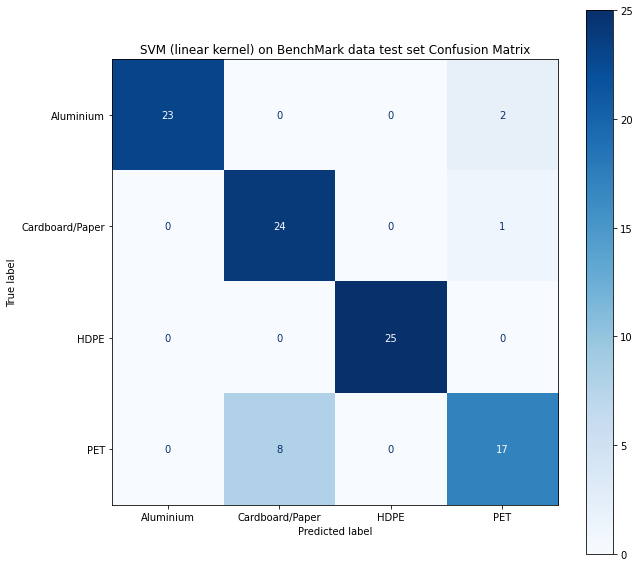

-----------------------------------------------------------------
SVM (linear kernel) classification on [NIR BenchMark data validation set] report: 

                 precision    recall  f1-score   support

      Aluminium       1.00      0.95      0.97        37
Cardboard/Paper       0.95      1.00      0.97        37
           HDPE       1.00      1.00      1.00        37
            PET       0.95      0.95      0.95        37

       accuracy                           0.97       148
      macro avg       0.97      0.97      0.97       148
   weighted avg       0.97      0.97      0.97       148



D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


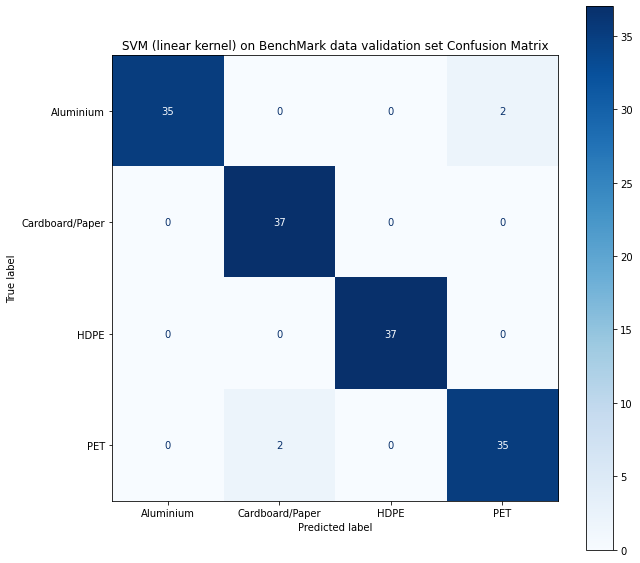

In [10]:
# build SVM Linear kernel model
SVMLinearModel=svm.LinearSVC(max_iter=10000)
SVMLinearModel = CalibratedClassifierCV(SVMLinearModel)

# -----training "NIR BenchMark data" using SVM Linear kernel model, also calculate training time-----
start = time.time()
SVMLinearModel1 = SVMLinearModel.fit(X_train, y_train_class.ravel()) # there using y_train_class, so we can see the label name on the Confusion Matrix
stop = time.time()
print(f"NIR BenchMark Data Training time: {stop - start}s")

print(f'SVM (linear kernel)\'s accuracy on BenchMark data training set is {100 * SVMLinearModel1.score(X_train, y_train_class):.2f}%')
print(f'SVM (linear kernel)\'s accuracy on BenchMark data validation set is {100 * SVMLinearModel1.score(X_validation, y_validation_class):.2f}%')
print(f'SVM (linear kernel)\'s accuracy on BenchMark data test set is {100 * SVMLinearModel1.score(X_test, y_test_class):.2f}%')
print('-----------------------------------------------------------------')

# predicting the "NIR BenchMark data" Test set results
y_predTest1 = SVMLinearModel1.predict(X_test)
# show precision, recall, accuracy, F-score evaluation metrics
print("SVM (linear kernel) classification on [NIR BenchMark data test set] report: \n")
print(classification_report(y_test_class, y_predTest1))

# Making the Confusion Matrix of the SVM Linear kernel model on test set
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(SVMLinearModel1, X_test, y_test_class, cmap = plt.cm.Blues, ax = ax).ax_.set_title('SVM (linear kernel) on BenchMark data test set Confusion Matrix')
plt.show()
print('-----------------------------------------------------------------')


# predicting the "NIR BenchMark data" Validation set results
y_predVal1 = SVMLinearModel1.predict(X_validation)
# show precision, recall, accuracy, F-score evaluation metrics
print("SVM (linear kernel) classification on [NIR BenchMark data validation set] report: \n")
print(classification_report(y_validation_class, y_predVal1))
# Making the Confusion Matrix of the SVM Linear kernel model on validation set
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(SVMLinearModel1, X_validation, y_validation_class, cmap = plt.cm.Blues, ax = ax).ax_.set_title('SVM (linear kernel) on BenchMark data validation set Confusion Matrix')
plt.show()

# 2. Deep Learning

## 2.1. SGD Optimizer

- BenchMark - build model

In [56]:
scaler = StandardScaler()
scaler.fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_validation = scaler.transform(X_validation)
Xs_test = scaler.transform(X_test)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xs_train, y_train, epochs=100, \
            validation_data=(Xs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xs_train, y_train, epochs=100, \
            validation_data=(Xs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 2.2030 - accuracy: 0.1446 - val_loss: 2.0171 - val_accuracy: 0.3108
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 1.9283 - accuracy: 0.3173 - val_loss: 1.8596 - val_accuracy: 0.3108
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 1.7732 - accuracy: 0.3133 - val_loss: 1.7225 - val_accuracy: 0.3649
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 1.6337 - accuracy: 0.3614 - val_loss: 1.5943 - val_accuracy: 0.5068
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 1.5061 - accuracy: 0.6787 - val_loss: 1.4807 - val_accuracy: 0.7297
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 1.3941 - accuracy: 0.7269 - val_loss: 1.3738 - val_accuracy: 0.5946
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 1.2821 - accuracy: 0.6064 - val_loss: 1.2699 - val_accuracy: 0.5743
Epoch 8/100
8/8 [=========

8/8 [==============================] - 0s 9ms/step - loss: 0.1854 - accuracy: 0.9518 - val_loss: 0.2844 - val_accuracy: 0.8851
Epoch 60/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1804 - accuracy: 0.9558 - val_loss: 0.2655 - val_accuracy: 0.8784
Epoch 61/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1745 - accuracy: 0.9639 - val_loss: 0.2616 - val_accuracy: 0.8851
Epoch 62/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1707 - accuracy: 0.9558 - val_loss: 0.2656 - val_accuracy: 0.8851
Epoch 63/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1660 - accuracy: 0.9639 - val_loss: 0.2563 - val_accuracy: 0.8851
Epoch 64/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1683 - accuracy: 0.9558 - val_loss: 0.2840 - val_accuracy: 0.8716
Epoch 65/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1705 - accuracy: 0.9679 - val_loss: 0.2498 - val_accuracy: 0.8784
Epoch 66/100
8/8 [=============

8/8 [==============================] - 0s 8ms/step - loss: 0.8294 - accuracy: 0.6988 - val_loss: 0.8530 - val_accuracy: 0.6824
Epoch 18/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7718 - accuracy: 0.7068 - val_loss: 0.8427 - val_accuracy: 0.6757
Epoch 19/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7129 - accuracy: 0.7470 - val_loss: 0.7515 - val_accuracy: 0.6959
Epoch 20/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6649 - accuracy: 0.7871 - val_loss: 0.6984 - val_accuracy: 0.8378
Epoch 21/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6169 - accuracy: 0.8755 - val_loss: 0.6577 - val_accuracy: 0.8446
Epoch 22/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5857 - accuracy: 0.8755 - val_loss: 0.6282 - val_accuracy: 0.8446
Epoch 23/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5475 - accuracy: 0.8996 - val_loss: 0.5928 - val_accuracy: 0.8919
Epoch 24/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.1293 - accuracy: 0.9719 - val_loss: 0.2099 - val_accuracy: 0.9257
Epoch 76/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1308 - accuracy: 0.9679 - val_loss: 0.2146 - val_accuracy: 0.9257
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1310 - accuracy: 0.9679 - val_loss: 0.2121 - val_accuracy: 0.9324
Epoch 78/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1290 - accuracy: 0.9719 - val_loss: 0.2110 - val_accuracy: 0.9257
Epoch 79/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1229 - accuracy: 0.9639 - val_loss: 0.2062 - val_accuracy: 0.9257
Epoch 80/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1328 - accuracy: 0.9679 - val_loss: 0.1942 - val_accuracy: 0.9324
Epoch 81/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1175 - accuracy: 0.9679 - val_loss: 0.1955 - val_accuracy: 0.9459
Epoch 82/100
8/8 [===============

- BenchMark - plot loss and acc

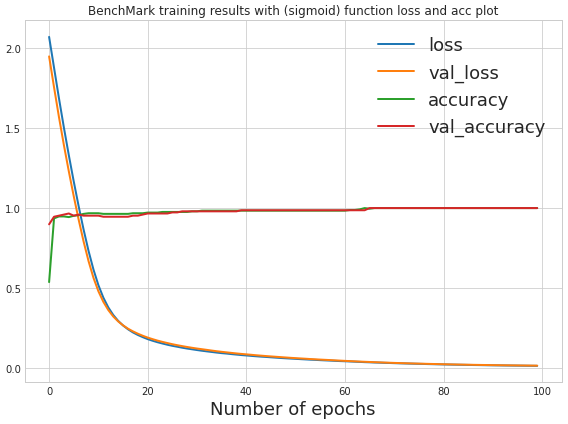

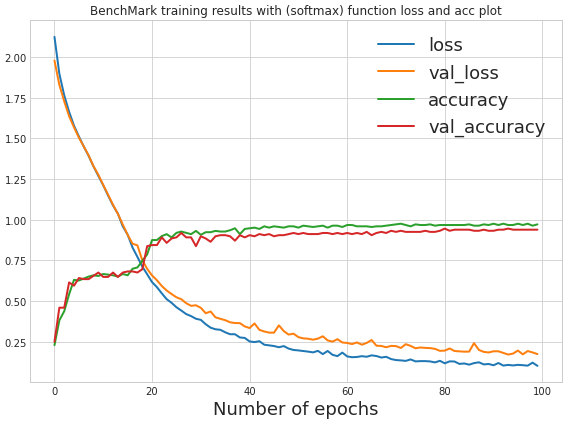

In [65]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('BenchMark training results with (sigmoid) function loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('BenchMark training results with (softmax) function loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- BenchMark - report

In [70]:
pred_train = model1.predict(Xs_train)
scores = model1.evaluate(Xs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xs_test)
scores2 = model1.evaluate(Xs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xs_train)
scores = model2.evaluate(Xs_train, y_train, verbose = 0)
print("Accuracy on (softmax) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xs_test)
scores2 = model2.evaluate(Xs_test, y_test, verbose = 0)
print("Accuracy on (softmax) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 3ms/step
Accuracy on (sigmoid) train data: 0.3453815281391144% 
 Error on train data: 0.6546184718608856
4/4 [==============================] - 0s 2ms/step
Accuracy on (sigmoid) test data: 0.30000001192092896% 
 Error on test data: 0.699999988079071
-----------------------------------------------------------------
8/8 [==============================] - 0s 2ms/step
Accuracy on (softmax) train data: 0.24497991800308228% 
 Error on train data: 0.7550200819969177
4/4 [==============================] - 0s 2ms/step
Accuracy on (softmax) test data: 0.25% 
 Error on test data: 0.75


- BenchMark - confusion matrix

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


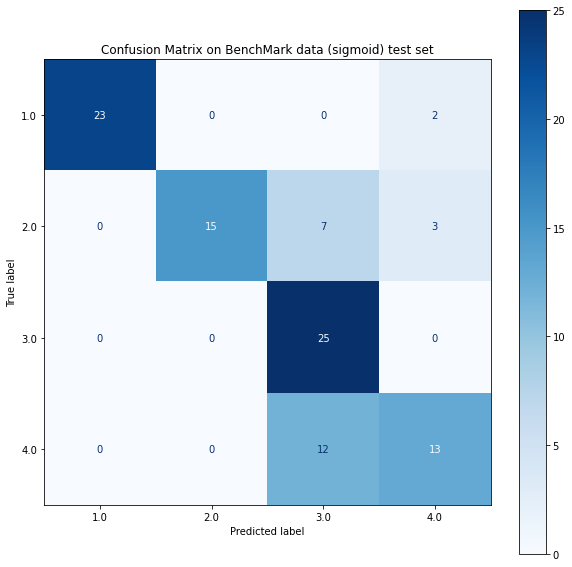

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 2ms/step


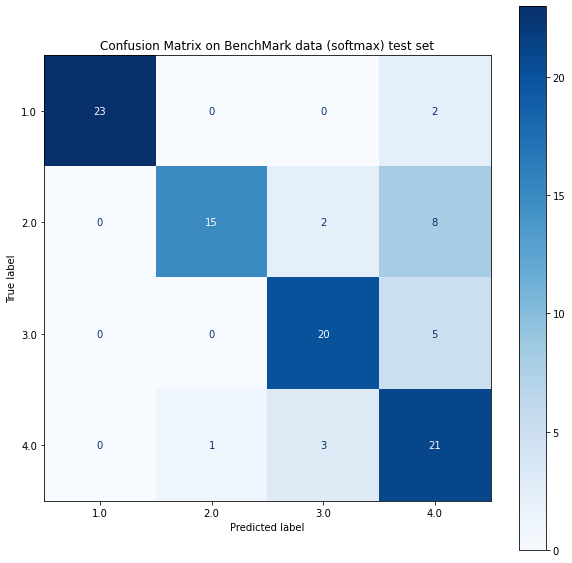

In [63]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on BenchMark data (sigmoid) test set')
# plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on BenchMark data (softmax) test set')
# plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

- MSC - build model

In [68]:
scaler = StandardScaler()
scaler.fit(Xmsc_train)
Xmscs_train = scaler.transform(Xmsc_train)
Xmscs_validation = scaler.transform(Xmsc_validation)
Xmscs_test = scaler.transform(Xmsc_test)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xmscs_train, y_train, epochs=100, \
            validation_data=(Xmscs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xmscs_train, y_train, epochs=100, \
            validation_data=(Xmscs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 30ms/step - loss: 2.5163 - accuracy: 0.0843 - val_loss: 2.3406 - val_accuracy: 0.1892
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 2.2104 - accuracy: 0.3213 - val_loss: 2.1331 - val_accuracy: 0.4865
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 2.0523 - accuracy: 0.5502 - val_loss: 1.9875 - val_accuracy: 0.5743
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 1.9281 - accuracy: 0.5823 - val_loss: 1.8604 - val_accuracy: 0.6216
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 1.8118 - accuracy: 0.7149 - val_loss: 1.7365 - val_accuracy: 0.8514
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 1.6894 - accuracy: 0.8956 - val_loss: 1.6012 - val_accuracy: 0.9257
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 1.5534 - accuracy: 0.9237 - val_loss: 1.4588 - val_accuracy: 0.9459
Epoch 8/100
8/8 [===

8/8 [==============================] - 0s 8ms/step - loss: 0.0447 - accuracy: 0.9920 - val_loss: 0.0497 - val_accuracy: 0.9865
Epoch 60/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0436 - accuracy: 0.9920 - val_loss: 0.0481 - val_accuracy: 0.9865
Epoch 61/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0424 - accuracy: 0.9920 - val_loss: 0.0468 - val_accuracy: 0.9865
Epoch 62/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0413 - accuracy: 0.9920 - val_loss: 0.0456 - val_accuracy: 0.9865
Epoch 63/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0403 - accuracy: 0.9920 - val_loss: 0.0445 - val_accuracy: 0.9865
Epoch 64/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0393 - accuracy: 0.9920 - val_loss: 0.0433 - val_accuracy: 0.9865
Epoch 65/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0383 - accuracy: 0.9920 - val_loss: 0.0421 - val_accuracy: 0.9865
Epoch 66/100
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 0.7420 - accuracy: 0.9438 - val_loss: 0.7742 - val_accuracy: 0.9324
Epoch 18/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6750 - accuracy: 0.9518 - val_loss: 0.7065 - val_accuracy: 0.9595
Epoch 19/100
8/8 [==============================] - 0s 7ms/step - loss: 0.6070 - accuracy: 0.9639 - val_loss: 0.6383 - val_accuracy: 0.9662
Epoch 20/100
8/8 [==============================] - 0s 8ms/step - loss: 0.5389 - accuracy: 0.9719 - val_loss: 0.5695 - val_accuracy: 0.9662
Epoch 21/100
8/8 [==============================] - 0s 8ms/step - loss: 0.4718 - accuracy: 0.9799 - val_loss: 0.5041 - val_accuracy: 0.9662
Epoch 22/100
8/8 [==============================] - 0s 8ms/step - loss: 0.4093 - accuracy: 0.9799 - val_loss: 0.4449 - val_accuracy: 0.9662
Epoch 23/100
8/8 [==============================] - 0s 8ms/step - loss: 0.3544 - accuracy: 0.9759 - val_loss: 0.3950 - val_accuracy: 0.9662
Epoch 24/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0347 - accuracy: 0.9960 - val_loss: 0.0954 - val_accuracy: 0.9797
Epoch 76/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0340 - accuracy: 0.9920 - val_loss: 0.0935 - val_accuracy: 0.9797
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9960 - val_loss: 0.0922 - val_accuracy: 0.9797
Epoch 78/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0322 - accuracy: 0.9960 - val_loss: 0.0911 - val_accuracy: 0.9797
Epoch 79/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0316 - accuracy: 0.9960 - val_loss: 0.0904 - val_accuracy: 0.9797
Epoch 80/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9960 - val_loss: 0.0897 - val_accuracy: 0.9797
Epoch 81/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.0890 - val_accuracy: 0.9797
Epoch 82/100
8/8 [===============

- MSC - plot loss and acc

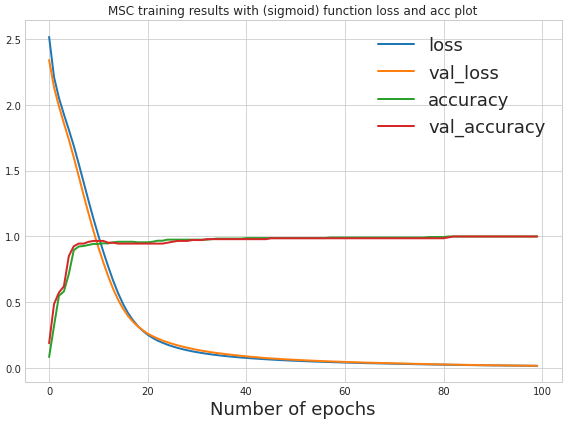

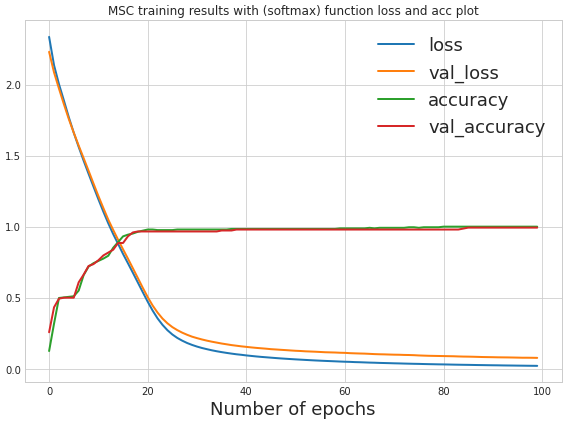

In [69]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('MSC training results with (sigmoid) function loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('MSC training results with (softmax) function loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- MSC - report

In [72]:
pred_train = model1.predict(Xmscs_train)
scores = model1.evaluate(Xmscs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xmscs_test)
scores2 = model1.evaluate(Xmscs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xmscs_train)
scores = model2.evaluate(Xmscs_train, y_train, verbose = 0)
print("Accuracy on (softmax) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xmscs_test)
scores2 = model2.evaluate(Xmscs_test, y_test, verbose = 0)
print("Accuracy on (softmax) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 2ms/step
Accuracy on (sigmoid) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 2ms/step
Accuracy on (sigmoid) test data: 0.9200000166893005% 
 Error on test data: 0.07999998331069946
-----------------------------------------------------------------
8/8 [==============================] - 0s 2ms/step
Accuracy on (softmax) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 1ms/step
Accuracy on (softmax) test data: 0.9700000286102295% 
 Error on test data: 0.029999971389770508


- MSC - confusion matrix

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


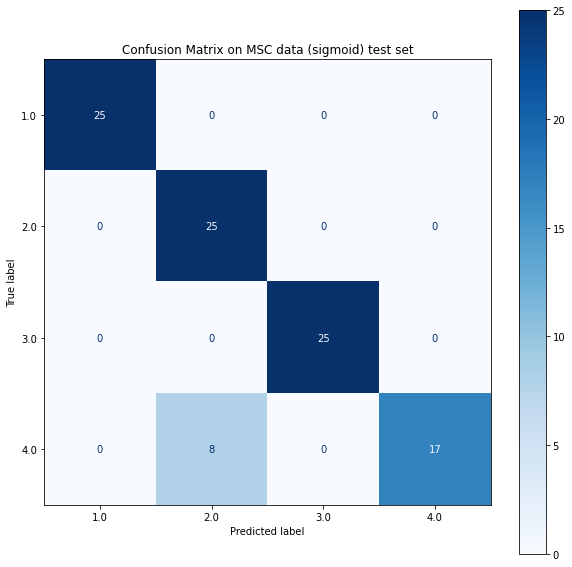

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


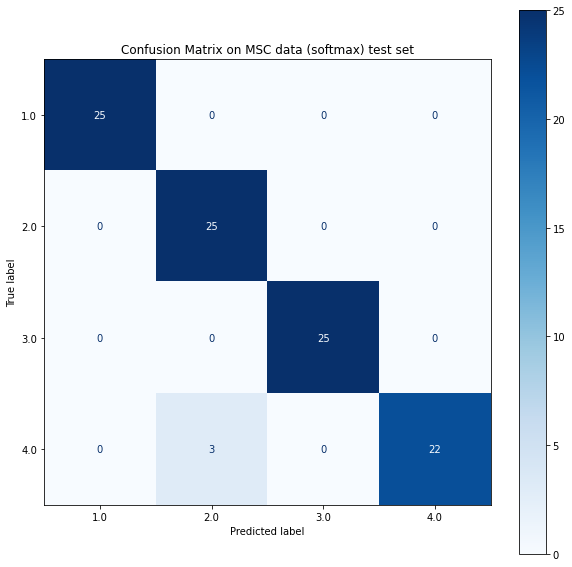

In [73]:
classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (sigmoid) test set')
# plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (softmax) test set')
# plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

- SNV - build model

In [74]:
scaler = StandardScaler()
scaler.fit(Xsnv_train)
Xsnvs_train = scaler.transform(Xsnv_train)
Xsnvs_validation = scaler.transform(Xsnv_validation)
Xsnvs_test = scaler.transform(Xsnv_test)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xsnvs_train, y_train, epochs=100, \
            validation_data=(Xsnvs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xsnvs_train, y_train, epochs=100, \
            validation_data=(Xsnvs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 31ms/step - loss: 1.9900 - accuracy: 0.3293 - val_loss: 1.8318 - val_accuracy: 0.3446
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 1.7524 - accuracy: 0.3896 - val_loss: 1.6448 - val_accuracy: 0.4122
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 1.5733 - accuracy: 0.5301 - val_loss: 1.4670 - val_accuracy: 0.6014
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 1.3993 - accuracy: 0.6265 - val_loss: 1.2939 - val_accuracy: 0.6622
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 1.2344 - accuracy: 0.6867 - val_loss: 1.1363 - val_accuracy: 0.6959
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 1.0786 - accuracy: 0.7751 - val_loss: 0.9813 - val_accuracy: 0.9324
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.9197 - accuracy: 0.9558 - val_loss: 0.8233 - val_accuracy: 0.9459
Epoch 8/100
8/8 [===

8/8 [==============================] - 0s 7ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 65/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 66/100
8/8 [===============

8/8 [==============================] - 0s 9ms/step - loss: 0.3596 - accuracy: 0.9679 - val_loss: 0.3265 - val_accuracy: 0.9595
Epoch 18/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2996 - accuracy: 0.9719 - val_loss: 0.2721 - val_accuracy: 0.9595
Epoch 19/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2480 - accuracy: 0.9799 - val_loss: 0.2266 - val_accuracy: 0.9595
Epoch 20/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2083 - accuracy: 0.9799 - val_loss: 0.1926 - val_accuracy: 0.9595
Epoch 21/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.9839 - val_loss: 0.1655 - val_accuracy: 0.9662
Epoch 22/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1538 - accuracy: 0.9880 - val_loss: 0.1431 - val_accuracy: 0.9797
Epoch 23/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1342 - accuracy: 0.9880 - val_loss: 0.1250 - val_accuracy: 0.9865
Epoch 24/100
8/8 [=============

8/8 [==============================] - 0s 9ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 76/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 77/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 78/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 79/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 80/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 81/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 82/100
8/8 [===============

- SNV - plot loss and acc

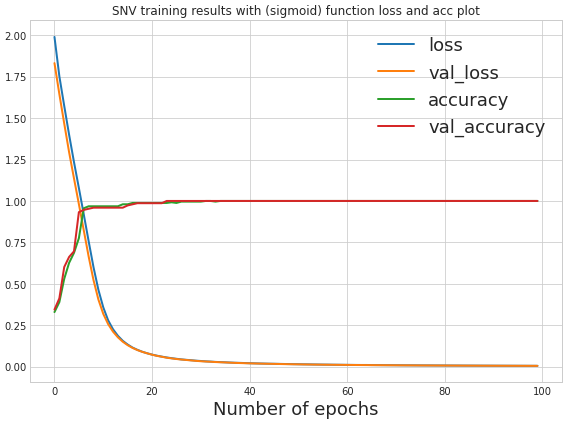

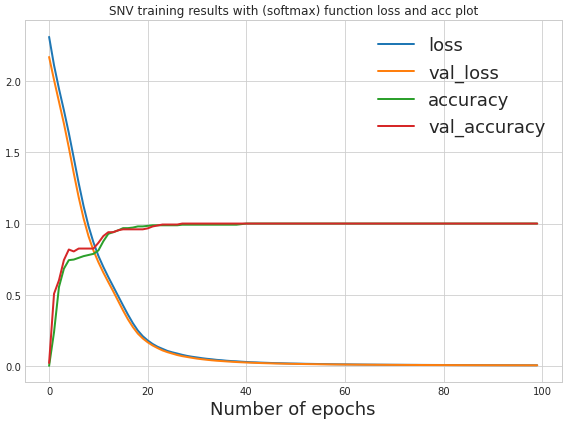

In [77]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('SNV training results with (sigmoid) function loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('SNV training results with (softmax) function loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- SNV - report

In [78]:
pred_train = model1.predict(Xsnvs_train)
scores = model1.evaluate(Xsnvs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xsnvs_test)
scores2 = model1.evaluate(Xsnvs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xsnvs_train)
scores = model2.evaluate(Xsnvs_train, y_train, verbose = 0)
print("Accuracy on (softmax) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xsnvs_test)
scores2 = model2.evaluate(Xsnvs_test, y_test, verbose = 0)
print("Accuracy on (softmax) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 1ms/step
Accuracy on (sigmoid) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 3ms/step
Accuracy on (sigmoid) test data: 0.9599999785423279% 
 Error on test data: 0.04000002145767212
-----------------------------------------------------------------
8/8 [==============================] - 0s 2ms/step
Accuracy on (softmax) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 1ms/step
Accuracy on (softmax) test data: 0.9700000286102295% 
 Error on test data: 0.029999971389770508


- SNV - confusion matrix

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


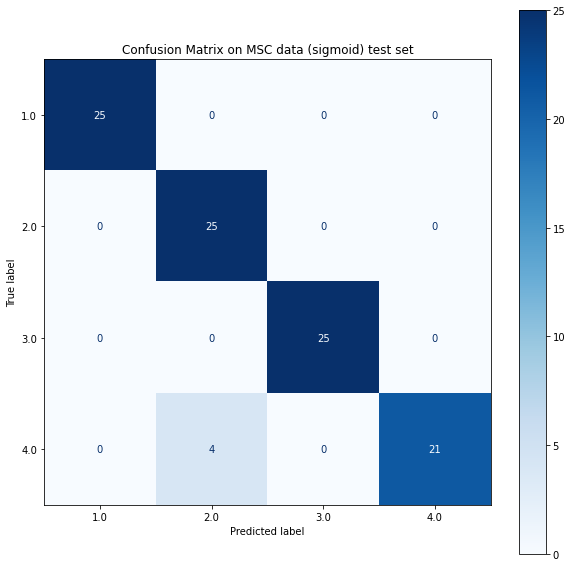

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 2ms/step


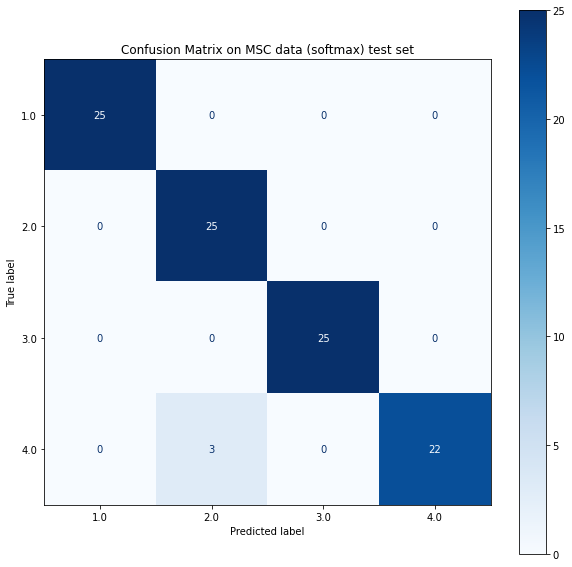

In [79]:
classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (sigmoid) test set')
# plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (softmax) test set')
# plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

## 2.2. Adam Optimizer

- BenchMark - build model

- BenchMark - plot loss and acc

- BenchMark - report

- BenchMark - confusion matrix

- MSC - build model

- MSC - plot loss and acc

- MSC - report

- MSC - confusion matrix

- SNV - build model

- SNV - plot loss and acc

- SNV - report

- SNV - confusion matrix